<a href="https://colab.research.google.com/github/jiuvvi/GraphCNNpred/blob/main/CNN_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [ ]:
!pip install pathlib2

## CNNPRed


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join
from sklearn.metrics import accuracy_score as accuracy, f1_score, mean_absolute_error as mae
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from pathlib2 import Path
from tensorflow.keras import backend as K, callbacks
import tensorflow as tf
import tensorflow.keras as keras



def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_pos = precision(y_true, y_pred)
    recall_pos = recall(y_true, y_pred)
    precision_neg = precision((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    recall_neg = recall((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    f_posit = 2 * ((precision_pos * recall_pos) / (precision_pos + recall_pos + K.epsilon()))
    f_neg = 2 * ((precision_neg * recall_neg) / (precision_neg + recall_neg + K.epsilon()))

    return (f_posit + f_neg) / 2


def load_data(file_fir):
    try:
        df_raw = pd.read_csv(file_fir, index_col='Date') # parse_dates=['Date'])
    except IOError:
        print("IO ERROR")
    return df_raw


def costruct_data_warehouse(ROOT_PATH, file_names):
    global number_of_stocks
    global samples_in_each_stock
    global number_feature
    global order_stocks
    data_warehouse = {}

    for stock_file_name in file_names:

        file_dir = os.path.join(ROOT_PATH, stock_file_name)
        ## Loading Data
        try:
            df_raw = load_data(file_dir)
        except ValueError:
            print("Couldn't Read {} file".format(file_dir))

        number_of_stocks += 1

        data = df_raw
        df_name = data['Name'][0]
        order_stocks.append(df_name)
        del data['Name']

        target = (data['Close'][predict_day:] / data['Close'][:-predict_day].values).astype(int)
        data = data[:-predict_day]
        target.index = data.index
        # Becasue of using 200 days Moving Average as one of the features
        data = data[200:]
        data = data.fillna(0)
        data['target'] = target
        target = data['target']
        # data['Date'] = data['Date'].apply(lambda x: x.weekday())
        del data['target']

        number_feature = data.shape[1]
        samples_in_each_stock = data.shape[0]

        train_data = data[data.index < '2014-04-21']
        train_data1 = scale(train_data)
        # print train_data.shape
        train_target1 = target[target.index < '2014-04-21']
        train_data = train_data1[:int(0.75 * train_data1.shape[0])]
        train_target = train_target1[:int(0.75 * train_target1.shape[0])]

        valid_data = scale(train_data1[int(0.75 * train_data1.shape[0]) - seq_len:])
        valid_target = train_target1[int(0.75 * train_target1.shape[0]) - seq_len:]

        data = pd.DataFrame(scale(data.values), columns=data.columns)
        data.index = target.index
        test_data = data[data.index >= '2014-04-21']
        test_target = target[target.index >= '2014-04-21']

        data_warehouse[df_name] = [train_data, train_target, np.array(test_data), np.array(test_target), valid_data,
                                   valid_target]

    return data_warehouse


def cnn_data_sequence_separately(tottal_data, tottal_target, data, target, seque_len):
    for index in range(data.shape[0] - seque_len + 1):
        tottal_data.append(data[index: index + seque_len])
        tottal_target.append(target[index + seque_len - 1])

    return tottal_data, tottal_target


def cnn_data_sequence(data_warehouse, seq_len):
    tottal_train_data = []
    tottal_train_target = []
    tottal_valid_data = []
    tottal_valid_target = []
    tottal_test_data = []
    tottal_test_target = []

    for key, value in data_warehouse.items():
        tottal_train_data, tottal_train_target = cnn_data_sequence_separately(tottal_train_data, tottal_train_target,
                                                                              value[0], value[1], seq_len)
        tottal_test_data, tottal_test_target = cnn_data_sequence_separately(tottal_test_data, tottal_test_target,
                                                                            value[2], value[3], seq_len)
        tottal_valid_data, tottal_valid_target = cnn_data_sequence_separately(tottal_valid_data, tottal_valid_target,
                                                                              value[4], value[5], seq_len)

    tottal_train_data = np.array(tottal_train_data)
    tottal_train_target = np.array(tottal_train_target)
    tottal_test_data = np.array(tottal_test_data)
    tottal_test_target = np.array(tottal_test_target)
    tottal_valid_data = np.array(tottal_valid_data)
    tottal_valid_target = np.array(tottal_valid_target)

    tottal_train_data = tottal_train_data.reshape(tottal_train_data.shape[0], tottal_train_data.shape[1],
                                                  tottal_train_data.shape[2], 1)
    tottal_test_data = tottal_test_data.reshape(tottal_test_data.shape[0], tottal_test_data.shape[1],
                                                tottal_test_data.shape[2], 1)
    tottal_valid_data = tottal_valid_data.reshape(tottal_valid_data.shape[0], tottal_valid_data.shape[1],
                                                  tottal_valid_data.shape[2], 1)

    return tottal_train_data, tottal_train_target, tottal_test_data, tottal_test_target, tottal_valid_data, tottal_valid_target


def sklearn_acc(model, test_data, test_target):
    overall_results = model.predict(test_data)
    test_pred = (overall_results > 0.5).astype(int)
    acc_results = [mae(overall_results, test_target), accuracy(test_pred, test_target),
                   f1_score(test_pred, test_target, average='macro')]

    return acc_results


def train(data_warehouse, i):
    seq_len = 60
    epochs = 200
    drop = 0.4

    global cnn_train_data, cnn_train_target, cnn_test_data, cnn_test_target, cnn_valid_data, cnn_valid_target

    if i == 1:
        print('sequencing ...')
        cnn_train_data, cnn_train_target, cnn_test_data, cnn_test_target, cnn_valid_data, cnn_valid_target = cnn_data_sequence(
            data_warehouse, seq_len)

    my_file = Path(join(Base_dir,
        '2D-models/best-{}-{}-{}-{}-{}.h5'.format(epochs, seq_len, number_filter, drop, i)))
    filepath = join(Base_dir, '2D-models/best-{}-{}-{}-{}-{}.h5'.format(epochs, seq_len, number_filter, drop, i))
    if my_file.is_file():
        print('loading model')

    else:

        print(' fitting model to target')
        model = Sequential()
        #
        # layer 1
        model.add(
            Conv2D(number_filter[0], (1, number_feature), activation='relu', input_shape=(seq_len, number_feature, 1)))
        # layer 2
        model.add(Conv2D(number_filter[1], (3, 1), activation='relu'))
        model.add(MaxPool2D(pool_size=(2, 1)))

        # layer 3
        model.add(Conv2D(number_filter[2], (3, 1), activation='relu'))
        model.add(MaxPool2D(pool_size=(2, 1)))

        model.add(Flatten())
        model.add(Dropout(drop))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='Adam', loss='mae', metrics=['acc', f1])

        best_model = callbacks.ModelCheckpoint(filepath, monitor='val_f1', verbose=0, save_best_only=True,
                                               save_weights_only=False, mode='max', period=1)


        model.fit(cnn_train_data, cnn_train_target, epochs=epochs, batch_size=128, verbose=1,
                        validation_data=(cnn_valid_data, cnn_valid_target), callbacks=[best_model])
    model = load_model(filepath, custom_objects={'f1': f1})

    return model, seq_len


def cnn_data_sequence_pre_train(data, target, seque_len):
    new_data = []
    new_target = []
    for index in range(data.shape[0] - seque_len + 1):
        new_data.append(data[index: index + seque_len])
        new_target.append(target[index + seque_len - 1])

    new_data = np.array(new_data)
    new_target = np.array(new_target)

    new_data = new_data.reshape(new_data.shape[0], new_data.shape[1], new_data.shape[2], 1)

    return new_data, new_target


def prediction(data_warehouse, model, seque_len, order_stocks, cnn_results):
    for name in order_stocks:
        value = data_warehouse[name]
        # train_data, train_target = cnn_data_sequence_pre_train(value[0], value[1], seque_len)
        test_data, test_target = cnn_data_sequence_pre_train(value[2], value[3], seque_len)
        # valid_data, valid_target = cnn_data_sequence_pre_train(value[4], value[5], seque_len)

        cnn_results.append(sklearn_acc(model, test_data, test_target)[2])

    return cnn_results


def run_cnn_ann(data_warehouse, order_stocks):
    cnn_results = []
    # dnn_results = []
    iterate_no = 4
    for i in range(1, iterate_no):
        K.clear_session()
        print(i)
        model, seq_len = train(data_warehouse, i)
        # cnn_results, dnn_results = prediction(data_warehouse, model, seq_len, order_stocks, cnn_results)
        cnn_results = prediction(data_warehouse, model, seq_len, order_stocks, cnn_results)

    cnn_results = np.array(cnn_results)
    cnn_results = cnn_results.reshape(iterate_no - 1, len(order_stocks))
    cnn_results = pd.DataFrame(cnn_results, columns=order_stocks)
    print(cnn_results.mean(), cnn_results.max(), cnn_results.std())
    cnn_results = cnn_results.append([cnn_results.mean(), cnn_results.max(), cnn_results.std()], ignore_index=True)
    cnn_results.to_csv(join(Base_dir, '2D-models/new results.csv'), index=False)


Base_dir = ''
TRAIN_ROOT_PATH = join(Base_dir, '/content/')
train_file_names = os.listdir(join(Base_dir, '/content/'))
train_file_names=['Processed_S&P.csv','Processed_RUSSELL.csv', 'Processed_NYSE.csv', 'Processed_NASDAQ.csv', 'Processed_DJI.csv']


# if moving average = 0 then we have no moving average
seq_len = 60
moving_average_day = 0
number_of_stocks = 0
number_feature = 0
samples_in_each_stock = 0
number_filter = [8, 8, 8]
predict_day = 1

cnn_train_data, cnn_train_target, cnn_test_data, cnn_test_target, cnn_valid_data, cnn_valid_target = ([] for i in
                                                                                                      range(6))

print('Loading train data ...')
order_stocks = []
data_warehouse = costruct_data_warehouse(TRAIN_ROOT_PATH, train_file_names)
# order_stocks = data_warehouse.keys()

print('number of stocks = '), number_of_stocks

run_cnn_ann(data_warehouse, order_stocks)

Loading train data ...
number of stocks = 
1
sequencing ...
 fitting model to target


Epoch 1/200
24/24 [==============================] - 2s 32ms/step - loss: 0.5012 - acc: 0.4968 - f1: 0.4870 - val_loss: 0.4967 - val_acc: 0.5550 - val_f1: 0.5046
Epoch 2/200
 9/24 [==========>...................] - ETA: 0s - loss: 0.4898 - acc: 0.5530 - f1: 0.5280

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 17ms/step - loss: 0.4855 - acc: 0.5587 - f1: 0.5102 - val_loss: 0.4896 - val_acc: 0.5459 - val_f1: 0.3891
Epoch 3/200
24/24 [==============================] - 0s 17ms/step - loss: 0.4752 - acc: 0.5441 - f1: 0.4008 - val_loss: 0.4719 - val_acc: 0.5523 - val_f1: 0.3551
Epoch 4/200
24/24 [==============================] - 0s 16ms/step - loss: 0.4655 - acc: 0.5408 - f1: 0.3583 - val_loss: 0.4618 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 5/200
24/24 [==============================] - 0s 17ms/step - loss: 0.4601 - acc: 0.5398 - f1: 0.3547 - val_loss: 0.4588 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 6/200
24/24 [==============================] - 0s 16ms/step - loss: 0.4589 - acc: 0.5421 - f1: 0.3564 - val_loss: 0.4572 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 7/200
24/24 [==============================] - 0s 15ms/step - loss: 0.4531 - acc: 0.5414 - f1: 0.3600 - val_loss: 0.4625 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 8/200
24/24 [=====================

Epoch 1/200
24/24 [==============================] - 2s 32ms/step - loss: 0.4882 - acc: 0.5344 - f1: 0.3804 - val_loss: 0.4663 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 2/200
10/24 [===========>..................] - ETA: 0s - loss: 0.4714 - acc: 0.5422 - f1: 0.3526

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 17ms/step - loss: 0.4690 - acc: 0.5391 - f1: 0.3492 - val_loss: 0.4537 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 3/200
24/24 [==============================] - 0s 16ms/step - loss: 0.4628 - acc: 0.5398 - f1: 0.3506 - val_loss: 0.4511 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 4/200
24/24 [==============================] - 1s 23ms/step - loss: 0.4600 - acc: 0.5398 - f1: 0.3489 - val_loss: 0.4492 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 5/200
24/24 [==============================] - 1s 24ms/step - loss: 0.4608 - acc: 0.5398 - f1: 0.3503 - val_loss: 0.4490 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 6/200
24/24 [==============================] - 1s 29ms/step - loss: 0.4599 - acc: 0.5398 - f1: 0.3506 - val_loss: 0.4484 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 7/200
24/24 [==============================] - 1s 25ms/step - loss: 0.4589 - acc: 0.5398 - f1: 0.3502 - val_loss: 0.4485 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 8/200
24/24 [=====================

Epoch 1/200
24/24 [==============================] - 2s 32ms/step - loss: 0.4945 - acc: 0.5328 - f1: 0.5167 - val_loss: 0.4853 - val_acc: 0.5820 - val_f1: 0.5134
Epoch 2/200
 9/24 [==========>...................] - ETA: 0s - loss: 0.4848 - acc: 0.5530 - f1: 0.5040

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 18ms/step - loss: 0.4820 - acc: 0.5501 - f1: 0.4862 - val_loss: 0.4703 - val_acc: 0.5820 - val_f1: 0.4341
Epoch 3/200
24/24 [==============================] - 0s 18ms/step - loss: 0.4706 - acc: 0.5438 - f1: 0.4084 - val_loss: 0.4544 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 4/200
24/24 [==============================] - 1s 27ms/step - loss: 0.4599 - acc: 0.5484 - f1: 0.3874 - val_loss: 0.4466 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 5/200
24/24 [==============================] - 1s 32ms/step - loss: 0.4523 - acc: 0.5461 - f1: 0.3823 - val_loss: 0.4456 - val_acc: 0.5532 - val_f1: 0.3555
Epoch 6/200
24/24 [==============================] - 1s 29ms/step - loss: 0.4520 - acc: 0.5557 - f1: 0.4246 - val_loss: 0.4434 - val_acc: 0.5640 - val_f1: 0.3940
Epoch 7/200
24/24 [==============================] - 1s 29ms/step - loss: 0.4423 - acc: 0.5597 - f1: 0.4356 - val_loss: 0.4434 - val_acc: 0.5595 - val_f1: 0.4138
Epoch 8/200
24/24 [=====================

AttributeError: 'DataFrame' object has no attribute 'append'

## Data load

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join
from sklearn.metrics import accuracy_score as accuracy, f1_score, mean_absolute_error as mae
import os


def load_data(file_fir):
    try:
        df_raw = pd.read_csv(file_fir, index_col='Date') # parse_dates=['Date'])
    except IOError:
        print("IO ERROR")
    return df_raw

file_fir='/content/Processed_RUSSELL.csv'
file_fir1='/content/Processed_S&P.csv'
file_fir2='/content/Processed_DJI.csv'
file_fir3='/content/Processed_NASDAQ.csv'
file_fir4='/content/Processed_NYSE.csv'
'''
file_fir='/content/Processed_DJI.csv'
file_fir1='/content/Processed_DJI.csv'
file_fir2='/content/Processed_NASDAQ.csv'
file_fir3='/content/Processed_NASDAQ.csv'
file_fir4='/content/Processed_NASDAQ.csv'
'''
#df_raw = pd.read_csv(file_fir, index_col='Date') # parse_dates=['Date'])
data=load_data(file_fir)
data
data2=load_data(file_fir2)
data2
data1=load_data(file_fir1)
data1
data3=load_data(file_fir3)
data4=load_data(file_fir4)
diff_list=['Close', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200']
#join(file_fir, file_fir1, file_fir2)
def merge_df(df_list):
  for i in range(len(df_list)):
    for j in df_list[i].columns:
      if j not in diff_list:

        del df_list[i][j]
      df_list[i].rename(columns={"Close": "Close"+str(i+1)}, inplace=True)

merge_df([data1,data2,data3,data4])
print(data1)
print(data)
print(data.keys())
df=pd.concat([data, data1,data2,data3,data4], axis=1)
#data.join(data1, how='inner',on=index)

print(df)
print(df.columns)
print(df['Close'])
print(df["Close1"])
print(len(df.columns))
#data=df




                 Close1    Volume       mom      mom1      mom2      mom3  \
Date                                                                        
2009-12-31  1115.099976       NaN       NaN       NaN       NaN       NaN   
2010-01-04  1132.989990  0.921723  0.016043       NaN       NaN       NaN   
2010-01-05  1136.520020 -0.375903  0.003116  0.016043       NaN       NaN   
2010-01-06  1137.140015  0.996234  0.000546  0.003116  0.016043       NaN   
2010-01-07  1141.689941  0.059932  0.004001  0.000546  0.003116  0.016043   
...                 ...       ...       ...       ...       ...       ...   
2017-11-09  2584.620117 -0.017375 -0.003762  0.001444 -0.000189  0.001271   
2017-11-10  2582.300049 -0.089962 -0.000898 -0.003762  0.001444 -0.000189   
2017-11-13  2584.840088 -0.024084  0.000984 -0.000898 -0.003762  0.001444   
2017-11-14  2578.870117  0.070184 -0.002310  0.000984 -0.000898 -0.003762   
2017-11-15  2564.620117 -0.022755 -0.005526 -0.002310  0.000984 -0.000898   

CNN_pred

Data preprocess

## data preprocessing for multi-class indices

In [ ]:

data=df
del data['Name']

predict_day = 1
split_rate=0.85
target_split_day='2016-04-21'
seq_len = 60
target=pd.DataFrame()
true_target = pd.DataFrame()

target["Close"] = (data['Close'][predict_day:] / data['Close'][:-predict_day].values).astype(int)
target["Close1"]=(data['Close1'][predict_day:] / data['Close1'][:-predict_day].values).astype(int)
target["Close2"]=(data['Close2'][predict_day:] / data['Close2'][:-predict_day].values).astype(int)
target["Close3"]=(data['Close3'][predict_day:] / data['Close3'][:-predict_day].values).astype(int)
target["Close4"]=(data['Close4'][predict_day:] / data['Close4'][:-predict_day].values).astype(int)

true_target["Close"] = data['Close'][predict_day:] / data['Close'][:-predict_day].values
true_target["Close1"] = data['Close1'][predict_day:] / data['Close1'][:-predict_day].values
true_target["Close2"] = data['Close2'][predict_day:] / data['Close2'][:-predict_day].values
true_target["Close3"] = data['Close3'][predict_day:] / data['Close3'][:-predict_day].values
true_target["Close4"] = data['Close4'][predict_day:] / data['Close4'][:-predict_day].values

data = data[:-predict_day]
target.index = data.index
true_target.index = data.index

# Becasue of using 200 days Moving Average as one of the features
data = data[200:]
target = target[200:]
true_target = true_target[200:]
data = data.fillna(0)

print(target,true_target)
number_feature = data.shape[1]
samples_in_each_stock = data.shape[0]
# scale data
def scale_data(data_):
  for i in data_.columns:
    data_[i]=scale(data_[i])
  return data_
data=scale_data(data)





train_data1 = data[data.index < target_split_day ]
train_target1 = target[target.index < target_split_day]
train_true_target1 = true_target[true_target.index < target_split_day]

train_data = train_data1[:int(split_rate * train_data1.shape[0])]
train_target = train_target1[:int(split_rate* train_target1.shape[0])]
train_true_target = train_true_target1[:int(split_rate * train_target1.shape[0])]

valid_data = train_data1[int(split_rate * train_data1.shape[0]) - seq_len:]
valid_target = train_target1[int(split_rate * train_target1.shape[0]) - seq_len:]
valid_true_target = train_true_target1[int(split_rate * train_target1.shape[0]) - seq_len:]


test_data = data[data.index >= target_split_day]
test_target = target[target.index >= target_split_day]
test_true_target = true_target[true_target.index >= target_split_day]
print(test_true_target)
print(train_true_target)
print(valid_true_target)
a = [np.array(train_data), np.array(train_target), np.array(test_data), np.array(test_target), np.array(valid_data), np.array(valid_target)]

def cnn_data_sequence_separately(tottal_data, tottal_target, tottal_return, data, target, t_return, seque_len):
    for index in range(data.shape[0] - seque_len + 1):
        #print(index,data[index: index + seque_len])
        tottal_data.append(data[index: index + seque_len])
        #print(tottal_data)
        #print(index,target[ index + seque_len])

        tottal_target.append(target[index + seque_len - 1])
        #print(tottal_target)
        tottal_return.append(t_return[index + seque_len - 1])


    return tottal_data, tottal_target,tottal_return


def cnn_data_sequence(data_warehouse, seq_len):
    tottal_train_data = []
    tottal_train_target = []
    tottal_valid_data = []
    tottal_valid_target = []
    tottal_test_data = []
    tottal_test_target = []
    tottal_train_return = []
    tottal_valid_return = []
    tottal_test_return = []


    value=a
    tottal_train_data, tottal_train_target, tottal_train_return= cnn_data_sequence_separately(tottal_train_data, tottal_train_target,tottal_train_return,
                                                                          value[0], value[1],np.array(train_true_target), seq_len)

    tottal_test_data, tottal_test_target, tottal_test_return= cnn_data_sequence_separately(tottal_test_data, tottal_test_target, tottal_test_return,
                                                                        value[2], value[3],np.array(test_true_target), seq_len)
    tottal_valid_data, tottal_valid_target,tottal_valid_return = cnn_data_sequence_separately(tottal_valid_data, tottal_valid_target,tottal_valid_return,
                                                                          value[4], value[5],np.array(valid_true_target), seq_len)

    tottal_train_data = np.array(tottal_train_data)
    tottal_train_target = np.array(tottal_train_target)
    tottal_test_data = np.array(tottal_test_data)
    tottal_test_target = np.array(tottal_test_target)
    tottal_valid_data = np.array(tottal_valid_data)
    tottal_valid_target = np.array(tottal_valid_target)
    tottal_train_return = np.array(tottal_train_return)
    tottal_valid_return = np.array(tottal_valid_return)
    tottal_test_return = np.array(tottal_test_return)

    tottal_train_data = tottal_train_data.reshape(tottal_train_data.shape[0], tottal_train_data.shape[1],
                                                  tottal_train_data.shape[2], 1)
    tottal_test_data = tottal_test_data.reshape(tottal_test_data.shape[0], tottal_test_data.shape[1],
                                                tottal_test_data.shape[2], 1)
    tottal_valid_data = tottal_valid_data.reshape(tottal_valid_data.shape[0], tottal_valid_data.shape[1],
                                                  tottal_valid_data.shape[2], 1)

    return tottal_train_data, tottal_train_target, tottal_test_data, tottal_test_target, tottal_valid_data, tottal_valid_target,tottal_train_return,tottal_valid_return,tottal_test_return
cnn_train_data, cnn_train_target, cnn_test_data, cnn_test_target, cnn_valid_data, cnn_valid_target,cnn_train_return,cnn_valid_return,cnn_test_return = cnn_data_sequence(
            a, seq_len)


            Close  Close1  Close2  Close3  Close4
Date                                             
2010-10-18      0       0       0       0       0
2010-10-19      1       1       1       1       1
2010-10-20      0       1       1       1       0
2010-10-21      1       1       0       1       1
2010-10-22      1       1       1       1       1
...           ...     ...     ...     ...     ...
2017-11-08      0       0       0       0       0
2017-11-09      1       0       0       1       0
2017-11-10      0       1       1       1       0
2017-11-13      0       0       0       0       0
2017-11-14      0       0       0       0       0

[1783 rows x 5 columns]                Close    Close1    Close2    Close3    Close4
Date                                                        
2010-10-18  0.977497  0.984123  0.985187  0.982380  0.980525
2010-10-19  1.011467  1.010524  1.011782  1.008388  1.013492
2010-10-20  0.994317  1.001774  1.003475  1.000928  0.998918
2010-10-21  1.007606

## data preprocessing for single-class indices

In [ ]:

del data['Name']

predict_day = 1
target_split_day='2014-08-12'
seq_len = 100
target = (data['Close'][predict_day:] / data['Close'][:-predict_day].values).astype(int)
true_target = data['Close'][predict_day:] / data['Close'][:-predict_day].values

data = data[:-predict_day]
target.index = data.index
true_target.index = data.index

# Becasue of using 200 days Moving Average as one of the features
data = data[200:]
data = data.fillna(0)

data['target'] = target
target = data['target']

# data['Date'] = data['Date'].apply(lambda x: x.weekday())
del data['target']

number_feature = data.shape[1]
samples_in_each_stock = data.shape[0]

train_data = data[data.index < target_split_day ]
train_data1 = scale(train_data)
#print train_data.shape
train_target1 = target[target.index < target_split_day]
train_true_target1 = true_target[true_target.index < target_split_day]

train_data = train_data1[:int(0.90 * train_data1.shape[0])]
train_target = train_target1[:int(0.90 * train_target1.shape[0])]
train_true_target = train_true_target1[:int(0.90 * train_target1.shape[0])]

valid_data = scale(train_data1[int(0.90 * train_data1.shape[0]) - seq_len:])
valid_target = train_target1[int(0.90 * train_target1.shape[0]) - seq_len:]
valid_true_target = train_true_target1[int(0.90 * train_target1.shape[0]) - seq_len:]

data = pd.DataFrame(scale(data.values), columns=data.columns)
data.index = target.index
test_data = data[data.index >= target_split_day]
test_target = target[target.index >= target_split_day]
test_true_target = true_target[true_target.index >= target_split_day]
print(test_true_target)
print(train_true_target)
print(valid_true_target)
a = [train_data, train_target, np.array(test_data), np.array(test_target), valid_data, valid_target]

def cnn_data_sequence_separately(tottal_data, tottal_target, tottal_return, data, target, t_return, seque_len):
    for index in range(data.shape[0] - seque_len + 1):
        tottal_data.append(data[index: index + seque_len])
        tottal_target.append(target[index + seque_len - 1])
        tottal_return.append(t_return[index + seque_len - 1])


    return tottal_data, tottal_target,tottal_return


def cnn_data_sequence(data_warehouse, seq_len):
    tottal_train_data = []
    tottal_train_target = []
    tottal_valid_data = []
    tottal_valid_target = []
    tottal_test_data = []
    tottal_test_target = []
    tottal_train_return = []
    tottal_valid_return = []
    tottal_test_return = []


    value=a
    tottal_train_data, tottal_train_target, tottal_train_return= cnn_data_sequence_separately(tottal_train_data, tottal_train_target,tottal_train_return,
                                                                          value[0], value[1],train_true_target, seq_len)

    tottal_test_data, tottal_test_target, tottal_test_return= cnn_data_sequence_separately(tottal_test_data, tottal_test_target, tottal_test_return,
                                                                        value[2], value[3],test_true_target, seq_len)
    tottal_valid_data, tottal_valid_target,tottal_valid_return = cnn_data_sequence_separately(tottal_valid_data, tottal_valid_target,tottal_valid_return,
                                                                          value[4], value[5],valid_true_target, seq_len)

    tottal_train_data = np.array(tottal_train_data)
    tottal_train_target = np.array(tottal_train_target)
    tottal_test_data = np.array(tottal_test_data)
    tottal_test_target = np.array(tottal_test_target)
    tottal_valid_data = np.array(tottal_valid_data)
    tottal_valid_target = np.array(tottal_valid_target)
    tottal_train_return = np.array(tottal_train_return)
    tottal_valid_return = np.array(tottal_valid_return)
    tottal_test_return = np.array(tottal_test_return)

    tottal_train_data = tottal_train_data.reshape(tottal_train_data.shape[0], tottal_train_data.shape[1],
                                                  tottal_train_data.shape[2], 1)
    tottal_test_data = tottal_test_data.reshape(tottal_test_data.shape[0], tottal_test_data.shape[1],
                                                tottal_test_data.shape[2], 1)
    tottal_valid_data = tottal_valid_data.reshape(tottal_valid_data.shape[0], tottal_valid_data.shape[1],
                                                  tottal_valid_data.shape[2], 1)

    return tottal_train_data, tottal_train_target, tottal_test_data, tottal_test_target, tottal_valid_data, tottal_valid_target,tottal_train_return,tottal_valid_return,tottal_test_return
cnn_train_data, cnn_train_target, cnn_test_data, cnn_test_target, cnn_valid_data, cnn_valid_target,cnn_train_return,cnn_valid_return,cnn_test_return = cnn_data_sequence(
            a, seq_len)


KeyError: 'Name'

## back to normal

In [ ]:
return_true_test=cnn_test_return-1
return_true_valid=cnn_valid_return-1
return_true_train=cnn_train_return-1

In [ ]:
print(np.sum(return_true_test>0)/(338*5))
print(np.sum(return_true_test<0)/(338*5))

1.3301775147928994
1.1627218934911243


Data visualization and threshold

In [ ]:
689/(689+134+823),134/(689+134+823),823/(689+134+823)

(0.41859052247873635, 0.08140947752126367, 0.5)

(1119, 5)
(209, 5)
(338, 5)
(1328, 5)
[[0.91090497 0.93336554 0.94453627 0.93100644 0.92949256]
 [0.94050048 0.95217955 0.95375091 0.94781959 0.94590736]
 [0.94102522 0.95540629 0.95689797 0.94924745 0.95423473]
 ...
 [1.0593593  1.04331531 1.03951563 1.04292702 1.04101175]
 [1.06423407 1.04629002 1.03977113 1.04688263 1.04682568]
 [1.06943583 1.04740685 1.04240788 1.05294593 1.05250455]]
[0.99699827 0.9981705  0.99825199 0.99780284 0.99771104] [1.00462865 1.00330659 1.00331869 1.00404483 1.00355042] [1.00100782 1.00054917 1.00051646 1.00088253 1.00046799]


(array([[  3.,   1.,  15.,  42.,  92., 110.,  49.,  20.,   5.,   1.],
        [  0.,   1.,   4.,  15., 129., 155.,  30.,   3.,   1.,   0.],
        [  0.,   1.,   2.,  11., 139., 152.,  28.,   4.,   1.,   0.],
        [  2.,   2.,   6.,  24., 100., 149.,  45.,   8.,   2.,   0.],
        [  0.,   2.,   4.,  17., 130., 148.,  32.,   4.,   1.,   0.]]),
 array([0.96888806, 0.9750968 , 0.98130554, 0.98751428, 0.99372302,
        0.99993176, 1.0061405 , 1.01234924, 1.01855798, 1.02476673,
        1.03097547]),
 <a list of 5 BarContainer objects>)

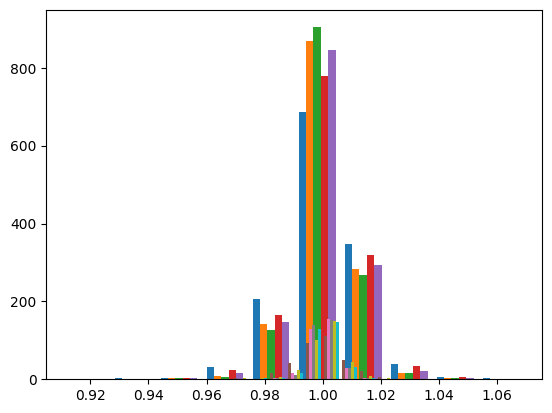

In [ ]:
print(cnn_train_return.shape)
print(cnn_valid_return.shape)
print(cnn_test_return.shape)
import matplotlib.pyplot as plt
c=np.append(cnn_train_return,cnn_valid_return,axis=0)
print(c.shape)
for i in range(5):
  c[:,i].sort()
print(c)
low_threshold=c[int(0.35*c.shape[0])]
low_threshold_=c[int(0.5*c.shape[0])]
high_threshold=c[int(0.65*c.shape[0])]
print(low_threshold,high_threshold,low_threshold_)
import matplotlib.pyplot as plt

%matplotlib inline




plt.hist(c)
plt.hist(cnn_test_return)



generate a new set of target(label)

In [ ]:
def return_to_label(return_np):

  new_1 = return_np>low_threshold
  #new_1 = return_np>1.000000
  #new_2 = return_np>1.000
  new_2 = return_np>high_threshold
  new3=new_1.astype(int)+new_2.astype(int)
  return new3
cnn_train_return=return_to_label(cnn_train_return)
cnn_test_return=return_to_label(cnn_test_return)
cnn_valid_return=return_to_label(cnn_valid_return)

In [ ]:
print(cnn_valid_return)

[[0 0 0 0 0]
 [0 1 1 0 1]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 1]
 [0 0 0 0 0]
 [2 2 2 2 2]
 [2 2 1 2 2]
 [2 2 1 2 2]
 [1 1 1 1 1]
 [1 2 2 1 2]
 [0 0 0 0 0]
 [2 1 2 2 1]
 [1 2 2 1 1]
 [1 1 1 1 1]
 [1 2 2 1 2]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 2 1 1]
 [2 1 1 1 2]
 [0 0 1 1 0]
 [0 2 2 1 2]
 [0 0 0 0 0]
 [2 2 2 2 2]
 [1 1 1 1 1]
 [1 0 0 1 0]
 [2 2 2 2 2]
 [1 2 1 1 2]
 [1 2 2 1 2]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [2 2 2 2 2]
 [1 2 1 2 2]
 [1 1 1 1 0]
 [2 1 1 2 1]
 [2 1 1 2 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [1 1 1 1 0]
 [1 0 0 1 0]
 [2 2 2 2 2]
 [1 1 1 1 1]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [1 0 0 1 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [1 0 1 1 0]
 [2 2 2 2 2]
 [0 1 1 0 1]
 [2 2 1 2 2]
 [2 2 2 2 2]
 [1 1 2 1 1]
 [1 2 2 1 2]
 [1 1 1 0 1]
 [1 1 1 1 1]
 [1 2 2 2 2]
 [0 0 0 0 0]
 [1 1 1 0 1]
 [0 0 0 0 0]
 [2 2 2 2 2]
 [1 1 0 1 1]
 [1 1 1 0 1]
 [2 1 1 2 2]
 [0 0 0 0 0]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [1 1 0 1 1]
 [0 0 1 0 0]
 [2 1 0 2 1]
 [1 1 0 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [2 2 2 1 2]

Generate graph


In [ ]:
threshold_edge=0.6
print(cnn_train_data.shape,cnn_train_target.shape)
train_data_size=cnn_train_data.shape[0]
cov_mat=np.corrcoef(a[0].T)

print(cov_mat.shape)
print(cnn_train_data.shape)
total_edge=np.sum(cov_mat>threshold_edge)
graph_info=np.ndarray(shape=(total_edge,2))
c=0
for i in range(number_feature):
  for j in range(number_feature):
    if cov_mat[i,j]>threshold_edge:
      graph_info[c]=[i,j]
      c+=1
#print(graph_info.shape)
#this also transpose
def form_graph_rep(size_batch):
    graph_info_rep=graph_info.reshape(-1,2)
    for i in range(size_batch-1):
      graph_info_rep=np.append(graph_info_rep,graph_info.reshape(-1,2)+number_feature*(i+1),axis=0)
    #print(graph_info_rep,graph_info_rep.shape)
    return np.transpose(graph_info_rep,(1,0))
print(form_graph_rep(3).shape)





'''

graph_info_rep=graph_info.reshape(1,-1,2)
for i in range(train_data_size-1):
  graph_info_rep=np.append(graph_info_rep,graph_info.reshape(1,-1,2),axis=0)


print(graph_info_rep.shape,graph_info_rep[1])
'''





(1119, 60, 138, 1) (1119, 5)
(138, 138)
(1119, 60, 138, 1)
(2, 4884)


'\n\ngraph_info_rep=graph_info.reshape(1,-1,2)\nfor i in range(train_data_size-1):\n  graph_info_rep=np.append(graph_info_rep,graph_info.reshape(1,-1,2),axis=0)\n\n\nprint(graph_info_rep.shape,graph_info_rep[1])\n'

# forming graph

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

!pip install torch-geometric
!pip install ogb

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 87.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (

In [ ]:
from __future__ import annotations

# from Python standard library
import copy
from pprint import pprint

# third-party libraries
import matplotlib.pyplot as plt
import networkx as nx
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


In [ ]:
print(cnn_train_data.shape)
print(cnn_train_target.shape)
print(cnn_test_data.shape)
print(cnn_test_target.shape)
print(cnn_valid_data.shape)
print(cnn_valid_target.shape)

(689, 60, 138, 1)
(689, 5)
(843, 60, 138, 1)
(843, 5)
(134, 60, 138, 1)
(134, 5)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms


from torch.utils.data import TensorDataset, DataLoader
dim_feature=cnn_train_data.shape[2]
print(dim_feature)
dim_target=cnn_train_target.shape[1]
print(dim_target)
tensor_x = torch.Tensor(np.transpose(cnn_train_data.reshape(-1,seq_len,dim_feature),(0,2,1))) # transform to torch tensor
#tensor_g = torch.Tensor(graph_info_rep)
tensor_y = torch.Tensor(cnn_train_target.reshape(-1,dim_target))
print(tensor_x.shape, tensor_y.shape)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=False)

tensor_x = torch.Tensor(np.transpose(cnn_valid_data.reshape(-1,seq_len,dim_feature),(0,2,1))) # transform to torch tensor
tensor_y = torch.Tensor(cnn_valid_target.reshape(-1,dim_target))

my_dataset_val = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader_val = DataLoader(my_dataset_val, batch_size=32, shuffle=False)
tensor_x = torch.Tensor(cnn_test_data.reshape(-1,seq_len,dim_feature)) # transform to torch tensor
tensor_y = torch.Tensor(cnn_test_target.reshape(-1,dim_target))

my_dataset_test = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader_test = DataLoader(my_dataset_test, batch_size=32, shuffle=False)

138
5
torch.Size([1119, 138, 60]) torch.Size([1119, 5])


In [ ]:
from torch.nn import LayerNorm, Linear, ReLU

class GAT(torch.nn.Module):
    def __init__(self,

                 hidden_dim: list, #hidden layer for gat/gcn channel
                 mid_dim:list, #fc layer
                 num_layers: int,
                 dropout: float,
                 num_stock: int,
                 conv_state_1: bool = False,
                 conv_state_2: bool = False,
                 gat_state = "gat",
                 filter_time=[8,1,8,3,1], #conc filter time
                 pooling_state="cnn"
                 ):
        """
        Args

        - hidden_dim: int, dimensions of hidden layers
        - num_layers: int, # of hidden layers
        - dropout: float, probability of dropout
        """
        super(GAT, self).__init__()

        # save all of the info
        self.mid_dim = mid_dim

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.num_stock = num_stock
        self.conv_state_1 = conv_state_1
        self.conv_state_2 = conv_state_2
        self.gat_state = gat_state
        self.filter_time=filter_time
        self.pool_state=pooling_state



        # a list of GATv2 layers, with dropout
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(num_layers):
            if self.gat_state=='gat':
              layer = pyg_nn.GATv2Conv(in_channels=hidden_dim[l],
                                       out_channels=hidden_dim[l+1],add_self_loops=False,
                                       dropout=dropout)
            elif self.gat_state=='gcn':



              layer = pyg_nn.GCNConv(in_channels=hidden_dim[l],
                                     out_channels=hidden_dim[l+1],add_self_loops=False)
            elif self.gat_state=='deepgcn':
              conv = pyg_nn.GENConv(hidden_dim[l], hidden_dim[l+1], aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
              norm = LayerNorm(hidden_dim[l+1])
              act = ReLU(inplace=True)

              layer =pyg_nn.DeepGCNLayer(conv, norm, act, block='res+', dropout=dropout,
                                  ckpt_grad=i % 3)
              #self.layers.append(layer)
            elif self.gat_state=='arma':
              layer=pyg_nn.ARMAConv(in_channels=hidden_dim[l],
                                     out_channels=hidden_dim[l+1],dropout=dropout)





            self.convs.append(layer)

            self.bns.append(nn.BatchNorm1d(hidden_dim[l+1]))

        # fully-connected final layer
        self.conv2d1=nn.Conv2d(in_channels=1,out_channels=self.filter_time[0],kernel_size=(1,5))
        self.conv2d2=nn.Conv2d(in_channels=self.filter_time[0],out_channels=self.filter_time[1],kernel_size=(1,5))
        self.conv2d3=nn.Conv2d(in_channels=1,out_channels=self.filter_time[2],kernel_size=(1,3))
        self.conv2d4=nn.Conv2d(in_channels=self.filter_time[2],out_channels=self.filter_time[3]*self.num_stock,kernel_size=(1,3))
        self.conv2d5=nn.Conv2d(in_channels=1,out_channels=self.filter_time[4],kernel_size=(number_feature,1))
        self.pooling1=nn.MaxPool2d((1,2))
        self.pooling2=nn.MaxPool2d((1,2))
        self.pooling3=nn.MaxPool2d((1,3))

        self.fc1 = nn.Linear(hidden_dim[-2], self.num_stock*mid_dim[0])
        #self.fc1 = nn.Linear(hidden_dim, 5*mid_dim[0])
        self.fc1_ = nn.Linear(hidden_dim[-1],mid_dim[0])
        self.fc2 = nn.Linear(mid_dim[0], mid_dim[1])
        self.drop1 = nn.Dropout(p=self.dropout)
        self.drop2 = nn.Dropout(p=self.dropout)
        self.fc3 = nn.Linear(mid_dim[1], mid_dim[2])


    def forward(self, x ,graph_data,batch) -> torch.Tensor:
        """
        Args
        - data: pyg.data.Batch, a batch of graphs

        Returns: torch.Tensor, shape [batch_size], unnormalized classification
            probability for each graph
        """
        #print(x.shape)
        if self.conv_state_1:
            x=x.reshape(-1,1,dim_feature,seq_len)


            x = self.conv2d1(x)
            x = F.relu(x)

            if not self.conv_state_2:
              x= self.pooling1(x)
              x=self.conv2d2(x)
              x = F.relu(x)

              x= self.pooling2(x)
             #here the dimension is batch*filter_time[1]* graph_node * hidden_dim[0](time) here to avoid shuffleing ,we set filtertime[1]=1


        x=x.reshape(-1,self.hidden_dim[0]*self.filter_time[1])



        graph_data=graph_data.to(torch.int64)
        batch=batch.to(torch.int64)
        #print(x.shape,'lall')

        for l, conv in enumerate(self.convs):
            #print(conv,x.dim(),x.shape,graph_data,graph_data.shape)
            #print(x,x.shape,edge_index,edge_index.shape,edge_attr,edge_attr.shape,batch)

            x = conv(x, graph_data)



            if l != self.num_layers - 1:

                x = self.bns[l](x)

                x = F.relu(x)
        if self.pool_state=="mean":

          x = pyg_nn.global_mean_pool(x, batch=batch)
        if self.pool_state=="max":

          x = pyg_nn.global_max_pool(x, batch=batch)
        #print(x.shape,'lll')
        if self.pool_state=="cnn":

          x = x.reshape(-1,1,number_feature,self.hidden_dim[-2])
          x = self.conv2d5(x)
          x = x.reshape(-1,self.hidden_dim[-2])

        #print(x.shape,'lal')

        if self.conv_state_2:

            x=x.reshape(-1,1,1,self.hidden_dim[-2])
            x=self.conv2d3(x)

            x = F.relu(x)
            x= self.pooling1(x)


            x=self.conv2d4(x)

            x = F.relu(x)
            x= self.pooling2(x)


            x=x.reshape(-1,self.num_stock,self.hidden_dim[-1])

            x = F.relu(self.fc1_(x))
            #print(x.shape)
        else:
            #print(x.shape,'not state2')
            x = F.relu(self.fc1(x))
            x=x.reshape(-1,self.num_stock,self.mid_dim[0])
            #print(x.shape,'k')

        x = self.drop1(x)
        '''
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        '''
        x = self.fc3(x)
        x = F.sigmoid(x)
        x = x.flatten(start_dim=1)
        #print(x.shape)
        return x




In [ ]:
def train(model: nn.Module, device: torch.device | str,
          data_loader: DataLoader, optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module, pbar: tqdm,num_stock=5) -> float:
    """Trains a GNN model.

    Args
    - model: nn.Module, GNN model, already placed on device
    - device: torch.device
    - data_loader: pyg.loader.DataLoader
    - optimizer: torch.optim.Optimizer
    - loss_fn: nn.Module

    Returns: (loss, acc)
    - loss: float, average per-graph loss across epoch
    - acc: float, accuracy
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    pbar.reset(len(data_loader))
    pbar.set_description('Training')

    for step,(x_data,target) in enumerate(data_loader):

        batch_size=target.size(dim=0)
        graph_data=torch.Tensor(form_graph_rep(batch_size))
        ''''
        print(batch_size,x_data,target)
        print(number_feature)

        print(np.arange(batch_size))
        print(np.repeat(np.arange(batch_size),number_feature))
        '''
        batch = torch.Tensor(np.repeat(np.arange(batch_size),number_feature))
        all_labels.append(target.detach())
        #print(graph_data.shape,"graph")
        batch = batch.to(device)
        x_data = x_data.to(device)
        graph_data = graph_data.to(device)
        target = target.to(device)

        #batch_size = batch.batch.max().item()

        preds = model(x_data,graph_data,batch)
        #print(preds,preds.shape,target.shape,target)


        all_preds.append(preds.detach().cpu())
        if num_stock==5:
          loss = loss_fn(preds.reshape(-1,5,3), target.reshape(-1,5,3))
        else:
          loss = loss_fn(preds, target.to(torch.float32))


        total_loss += loss.item() * batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.update()

    all_preds = (torch.cat(all_preds).view(-1) > 0).to(torch.int32)
    all_labels = torch.cat(all_labels).view(-1)
    acc = (all_preds == all_labels).sum() / len(all_labels)
    avg_loss = total_loss / len(all_labels)
    return avg_loss, acc
def eval(model: nn.Module, device: torch.device, loader: DataLoader,
         evaluator: Evaluator, pbar: tqdm) -> dict[str, float]:
    """Evaluates the AUROC of a model on a dataset split.

    Args
    - model: nn.Module, GNN model, already moved to device
    - device: torch.device
    - loader: DataLoader
    - evaluator: Evaluator from OGB
    - pbar: tqdm, progress bar

    Returns: dict, with one (key, value)
    - key is dataset.eval_metric (which in this case is 'rocauc')
    - value is the AUROC
    """
    model.eval()
    y_true = []
    y_pred = []

    pbar.reset(total=len(loader))
    pbar.set_description('Evaluating')

    for step,(x_data,target) in enumerate(loader):
        y_true.append(target.detach())
        batch_size=target.size(dim=0)
        graph_data=torch.Tensor(form_graph_rep(batch_size))

        batch = torch.Tensor(np.repeat(np.arange(batch_size),number_feature))

        batch = batch.to(device)
        x_data = x_data.to(device)
        graph_data = graph_data.to(device)
        target = target.to(device)


        #batch_size = batch.batch.max().item()
        with torch.no_grad():

            pred = model(x_data,graph_data,batch)


        y_pred.append(pred.detach().cpu())
        pbar.update()


    all_preds = (torch.cat(y_pred).view(-1) > 0).to(torch.int32)
    all_labels = torch.cat(y_true).view(-1)
    acc = (all_preds == all_labels).sum() / len(all_labels)
    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()

    input_dict = {'y_true': y_true, 'y_pred': y_pred}
    return evaluator.eval(input_dict),acc

# A simple model with 1 dim target

In [ ]:
model = GAT(node_dim=seq_len,
            hidden_dim=seq_len,
            num_layers=4,
            mid_dim=[100,200,1],

            dropout=0.5)
model = model.to(device)

# use the official OGB evaluator, which will compute AUROC for us
evaluator = Evaluator(name='ogbg-molhiv')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.BCEWithLogitsLoss()
num_epochs = 20
best_model = None
best_valid_auroc = 0

# track the train/valid AUROC and train loss across epochs of training
train_losses = []
train_aurocs = []
valid_aurocs = []

pbar = tqdm()

for epoch in range(1, 1 + num_epochs):
    loss, acc = train(model, device, my_dataloader, optimizer, loss_fn, pbar)

    train_result,acc_train = eval(model, device, my_dataloader, evaluator, pbar)
    val_result,acc_val = eval(model, device, my_dataloader_val, evaluator, pbar)

    train_auroc, valid_auroc = train_result['rocauc'], val_result['rocauc']
    if valid_auroc > best_valid_auroc:
        best_valid_auroc = valid_auroc
        best_model = copy.deepcopy(model)
    tqdm.write(f'Epoch {epoch:02d}, loss: {loss:.4f}, '
               f'train acc: {100 * acc:.2f}%, '
               f'train auroc: {train_auroc:.4f}, '
               f'valid auroc: {valid_auroc:.4f}'
               f'valid acc: {100 * acc_val:.2f}%, ')

    train_losses.append(loss)
    train_aurocs.append(train_auroc)
    valid_aurocs.append(valid_auroc)
val_result,acc_val = eval(best_model, device, my_dataloader_test, evaluator, pbar)
print('test acc',acc_val)

0it [00:00, ?it/s]

NameError: ignored

# 3 dim target

### single index encoding

In [ ]:
total_stock_index=1
def positional_encoding(return_l):
  data_size=return_l.shape[0]
  return_true=np.zeros(shape=[data_size,3])
  for i in range(data_size):
    return_true[i,return_l[i]]=1
  return return_true

cnn_train_target=positional_encoding(cnn_train_return)

cnn_valid_target=positional_encoding(cnn_valid_return)

cnn_test_target=positional_encoding(cnn_test_return)

'''
cnn_train_target=cnn_train_return

cnn_valid_target=cnn_valid_return
'''
print(cnn_train_data.shape, cnn_valid_data.shape, cnn_train_target.shape,cnn_test_target.shape,cnn_train_target.shape,cnn_valid_target.shape )

(1061, 30, 138, 1) (123, 30, 138, 1) (1061, 3) (542, 3) (1061, 3) (123, 3)


### multi-indices encoding

In [ ]:
total_stock_index=5
def positional_encoding(return_l):
  data_size=return_l.shape[0]
  return_true=np.zeros(shape=[data_size,3*total_stock_index])
  for i in range(data_size):
    for j in range(5):
      return_true[i,j*3+return_l[i,j]]=1
  return return_true

cnn_train_target=positional_encoding(cnn_train_return)

cnn_valid_target=positional_encoding(cnn_valid_return)

cnn_test_target=positional_encoding(cnn_test_return)

'''
cnn_train_target=cnn_train_return

cnn_valid_target=cnn_valid_return
'''
print(cnn_train_data.shape, cnn_valid_data.shape, cnn_train_target.shape,cnn_test_target.shape,cnn_train_target.shape,cnn_valid_target.shape )

(1119, 60, 138, 1) (209, 60, 138, 1) (1119, 15) (338, 15) (1119, 15) (209, 15)


### back to normal

In [ ]:


tensor_x = torch.Tensor(np.transpose(cnn_train_data.reshape(-1,seq_len,dim_feature),(0,2,1))) # transform to torch tensor
#tensor_g = torch.Tensor(graph_info_rep)
tensor_y = torch.Tensor(cnn_train_target.reshape(-1,3*total_stock_index))

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=64, shuffle=True)

tensor_x = torch.Tensor(np.transpose(cnn_valid_data.reshape(-1,seq_len,dim_feature),(0,2,1))) # transform to torch tensor
tensor_y = torch.Tensor(cnn_valid_target.reshape(-1,3*total_stock_index))

my_dataset_val = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader_val = DataLoader(my_dataset_val, batch_size=32, shuffle=False)
tensor_x = torch.Tensor(cnn_test_data.reshape(-1,seq_len,dim_feature)) # transform to torch tensor
tensor_y = torch.Tensor(cnn_test_target.reshape(-1,3*total_stock_index))

my_dataset_test = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader_test = DataLoader(my_dataset_test, batch_size=32, shuffle=False)

In [ ]:
from sklearn.metrics import f1_score
def eval_1(model: nn.Module, device: torch.device, loader: DataLoader,
         evaluator: Evaluator, pbar: tqdm,num_stock: int,f_1_state: bool=False) -> dict[str, float]:
    """Evaluates the AUROC of a model on a dataset split.

    Args
    - model: nn.Module, GNN model, already moved to device
    - device: torch.device
    - loader: DataLoader
    - evaluator: Evaluator from OGB
    - pbar: tqdm, progress bar

    Returns: dict, with one (key, value)
    - key is dataset.eval_metric (which in this case is 'rocauc')
    - value is the AUROC
    """
    model.eval()
    y_true = []
    y_pred = []
    y_true_f1 = []

    test_total=0
    test_correct=0
    test_loss=0

    pbar.reset(total=len(loader))
    pbar.set_description('Evaluating')
    total_length=0
    for step,(x_data,target) in enumerate(loader):
        #y_true.append(target.detach())
        batch_size=target.size(dim=0)
        total_length+=batch_size
        graph_data=torch.Tensor(form_graph_rep(batch_size))

        batch = torch.Tensor(np.repeat(np.arange(batch_size),number_feature))

        batch = batch.to(device)
        x_data = x_data.to(device)
        graph_data = graph_data.to(device)
        target = target.to(device)


        #batch_size = batch.batch.max().item()
        with torch.no_grad():

            pred = model(x_data,graph_data,batch).detach().cpu()
            target= target.detach().cpu()
            if num_stock==5:
              pred=pred.reshape(-1,5,3)
              target=target.reshape(-1,5,3)


            #print(pred,target,pred.shape,target.shape)
            _, predicted = torch.max(pred, 2)
            _,labels = torch.max(target,2)

            _, predicted_f1 = torch.max(pred[:,:,(0,2)], 2)
            y_true.append(predicted.detach())
            y_pred.append(labels.detach())
            y_true_f1.append( predicted_f1.detach())




            test_total += labels.size(0)*num_stock

            test_correct += (predicted == labels).sum().item()
            #print(pred.shape,target.shape,labels.shape)
            # find loss
            if num_stock==5:
                loss = loss_fn(pred.reshape(-1,5,3).to(torch.float32), target.reshape(-1,5,3).to(torch.float32))
            else:
                loss = loss_fn(pred, labels.to(torch.float32))


            test_loss += loss.item()



        pbar.update()
    predicted_f1_np=np.zeros(shape=(total_length,5))
    labels_np=np.zeros(shape=(total_length,5))
    #print(total_length)
    count=0
    for i in range(len(y_true)):
      predicted_f1_np[count:count+y_true_f1[i].shape[0],:]=y_true_f1[i].numpy()

      labels_np[count:count+y_pred[i].shape[0],:]=y_pred[i].numpy()
      count+=y_true_f1[i].shape[0]
    #print(count)

    if f_1_state:
      f1_=np.zeros(shape=(5))


      labels=(0.5*labels_np).astype(int)

      f1_[0]=f1_score(labels[:,0],predicted_f1_np[:,0],average='macro')
      f1_[1]=f1_score(labels[:,1],predicted_f1_np[:,1],average='macro')
      f1_[2]=f1_score(labels[:,2],predicted_f1_np[:,2],average='macro')
      f1_[3]=f1_score(labels[:,3],predicted_f1_np[:,3],average='macro')
      f1_[4]=f1_score(labels[:,4],predicted_f1_np[:,4],average='macro')


    #print(test_correct,test_total)
    acc = test_correct/test_total
    score= test_loss/len(loader)



    return acc, score if not f_1_state else f1_,y_true,y_pred

In [ ]:
# if True False [seq_len-48,30,20,10] [seq_len,30,19,9]，,10,10,10,10,10,10,10,10,12,12],,7,2,3,5,5,5,5,5,5,3],,8,8,8,8,8,8]
model = GAT(
            hidden_dim=[seq_len-48,12,12,12,12,12,12],
            num_layers=0,
            mid_dim=[20,20,3],
            dropout=0.5,
            num_stock=5,
            conv_state_1=True,
            conv_state_2=False,
            gat_state='arma',
            pooling_state="cnn")
model = model.to(device)

# use the official OGB evaluator, which will compute AUROC for us
evaluator = Evaluator(name='ogbg-molhiv')
weights = [0.4,0.1,0.5] #[ 1 / number of instances for each class]
class_weights = torch.FloatTensor(weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
#loss_fn = nn.CrossEntropyLoss(weight=class_weights)
loss_fn = nn.CrossEntropyLoss(weight=torch.as_tensor(np.array(weights)))
loss_fn = nn.CrossEntropyLoss()
num_epochs = 300
best_model = None
best_valid_auroc = 0

# track the train/valid AUROC and train loss across epochs of training

train_losses = []
train_sharpe_l = []
valid_sharpe_l = []
test_sharpe_l = []

ceq_l = []
ceq_l_ind=np.zeros(shape=(num_epochs,5))
sharpe_l_ind=np.zeros(shape=(num_epochs,5))
score_t = np.zeros(shape=(num_epochs,5))

count=0
pbar = tqdm()

for epoch in range(1, 1 + num_epochs):
    loss, acc = train(model, device, my_dataloader, optimizer, loss_fn, pbar,num_stock=5)
    print(loss)

    acc_train, score_train,y_true,y_pred = eval_1(model, device, my_dataloader, evaluator, pbar,num_stock=5,f_1_state=True)
    #print(y_true,return_true_train.shape,y_pred)
    _,_,_,_,train_sharpe,_,_,_,_=sharpe(y_true,return_true_train,y_pred,True)
    acc_val,score_val,y_true,y_pred = eval_1(model, device, my_dataloader_val, evaluator, pbar,num_stock=5,f_1_state=True)
    #print(np.sqrt(252)*np.mean(np.sum(return_true_valid,axis=1))/np.std(np.sum(return_true_valid,axis=1)))
    #print(np.sqrt(252)*np.mean(return_true_valid)/np.std(return_true_valid))
    _1,_2,_,_,val_sharpe,val_1,all_v_sharpe,ceq_0_v,ceq_1_v=sharpe(y_true,return_true_valid,y_pred,True)
    acc_test,score_test,y_true,y_pred = eval_1(model, device, my_dataloader_test, evaluator, pbar,num_stock=5,f_1_state=True)
    _3,_4,_,_,test_sharpe,test_1,all_t_sharpe,ceq_0_t,ceq_1_t=sharpe(y_true,return_true_test,y_pred,True)

    tqdm.write(f'Epoch {epoch:02d}, loss: {loss:.4f}, '
               f'train acc: {100 * acc:.2f}%, '
               f'train sharpe: {train_sharpe:.5f}, '
               f'valid acc: {100 * acc_val:.2f}%, '
               f'valid sharpe: {val_sharpe:.5f}, '
               f'valid count: {_1,_2}, '
               f'valid all long sharpe: {all_v_sharpe:.5f}%, '

               #f'test acc: {100 * acc_test:.2f}%, '
               f'test sharpe: {test_sharpe:.5f}%, '
               f'test count: {_3,_4}%, '
               f'test all long sharpe: {all_t_sharpe:.5f}%, '

               f'test ceq: {ceq_0_t:.5f}, '
               )
    print(score_test)
    #print(test_1,ceq_1_t)


    train_sharpe_l.append(train_sharpe)
    valid_sharpe_l.append(val_sharpe)
    test_sharpe_l.append(test_sharpe)
    ceq_l.append(ceq_0_t)
    ceq_l_ind[epoch-1,:]=ceq_1_t
    sharpe_l_ind[epoch-1,:]=test_1
    score_t[epoch-1,:]=score_test





0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0.1788407299324697


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  

Epoch 01, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17885986476701607


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 02, loss: 0.1789, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.178848443813966


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 03, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17884125712374543


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 04, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17883085349432087


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 05, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17883379691620827


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 06, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17884028386174833


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 07, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.1788110065715882


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 08, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17884746425947973


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 09, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17884201301788338


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 10, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17881181338801425


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 11, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17878483105245574


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 12, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.1788095677790274


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 13, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17882694601479973


<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide

Epoch 14, loss: 0.1788, train acc: 33.33%, train sharpe: nan, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17880546554483612


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 15, loss: 0.1788, train acc: 33.33%, train sharpe: 0.63667, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17881691528993027


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 16, loss: 0.1788, train acc: 33.33%, train sharpe: -0.83786, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.1788085811508174


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 17, loss: 0.1788, train acc: 33.33%, train sharpe: 0.13132, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17881108041955915


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 18, loss: 0.1788, train acc: 33.33%, train sharpe: 0.65015, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17879178122746864


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 19, loss: 0.1788, train acc: 33.33%, train sharpe: -0.36131, valid acc: 26.79%, valid sharpe: nan, valid count: (0, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41319444 0.43478261 0.43572621 0.42320819 0.43853821]
0.17878540834217224


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 20, loss: 0.1788, train acc: 33.33%, train sharpe: -0.03146, valid acc: 26.89%, valid sharpe: 1.10070, valid count: (1, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41217391 0.43478261 0.43572621 0.42320819 0.43853821]
0.178781813441695


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 21, loss: 0.1788, train acc: 33.33%, train sharpe: -0.04262, valid acc: 26.89%, valid sharpe: -0.20418, valid count: (6, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41217391 0.43478261 0.43572621 0.42320819 0.43853821]
0.17878202134951404


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 22, loss: 0.1788, train acc: 33.33%, train sharpe: -0.58901, valid acc: 26.89%, valid sharpe: 0.08394, valid count: (6, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41217391 0.43478261 0.43572621 0.43492063 0.43853821]
0.1787536088575875


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 23, loss: 0.1788, train acc: 33.33%, train sharpe: -0.29229, valid acc: 26.79%, valid sharpe: -1.44673, valid count: (18, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41217391 0.43478261 0.43572621 0.42320819 0.43853821]
0.17877596659712894


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:51: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 24, loss: 0.1788, train acc: 33.33%, train sharpe: 0.00403, valid acc: 26.70%, valid sharpe: -1.24171, valid count: (14, 0), valid all long sharpe: -0.25663%, test sharpe: nan%, test count: (0, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41217391 0.43478261 0.43572621 0.43492063 0.43853821]
0.17876292978115724


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 25, loss: 0.1788, train acc: 33.33%, train sharpe: 0.18882, valid acc: 26.99%, valid sharpe: -2.20276, valid count: (22, 0), valid all long sharpe: -0.25663%, test sharpe: 1.23608%, test count: (4, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00007, 
[0.41217391 0.43478261 0.43572621 0.42320819 0.43853821]
0.17873520954826386


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 26, loss: 0.1787, train acc: 33.33%, train sharpe: -1.56785, valid acc: 26.89%, valid sharpe: -1.59301, valid count: (22, 0), valid all long sharpe: -0.25663%, test sharpe: 0.86474%, test count: (1, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00004, 
[0.41217391 0.43478261 0.43572621 0.43492063 0.43853821]
0.178740279178091


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 27, loss: 0.1787, train acc: 33.33%, train sharpe: -0.57637, valid acc: 27.27%, valid sharpe: -1.88424, valid count: (62, 0), valid all long sharpe: -0.25663%, test sharpe: 0.18860%, test count: (6, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00001, 
[0.41217391 0.43478261 0.43572621 0.43492063 0.43853821]
0.17870790527305114


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 28, loss: 0.1787, train acc: 33.33%, train sharpe: -0.08559, valid acc: 28.04%, valid sharpe: -0.42509, valid count: (40, 0), valid all long sharpe: -0.25663%, test sharpe: 1.17447%, test count: (3, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00007, 
[0.41217391 0.43478261 0.43572621 0.44273938 0.43853821]
0.17870918742098338


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 29, loss: 0.1787, train acc: 33.33%, train sharpe: 0.22038, valid acc: 27.75%, valid sharpe: -2.17131, valid count: (98, 0), valid all long sharpe: -0.25663%, test sharpe: -0.90527%, test count: (20, 0)%, test all long sharpe: 1.81492%, test ceq: -0.00010, 
[0.41217391 0.43478261 0.43572621 0.43492063 0.43853821]
0.17869535796444155


<ipython-input-55-6143b2cc52b9>:52: RuntimeWarning: invalid value encountered in divide
  sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)


Epoch 30, loss: 0.1787, train acc: 33.33%, train sharpe: -0.30543, valid acc: 28.23%, valid sharpe: -1.41944, valid count: (79, 0), valid all long sharpe: -0.25663%, test sharpe: 0.01511%, test count: (15, 0)%, test all long sharpe: 1.81492%, test ceq: 0.00000, 
[0.41217391 0.43478261 0.43572621 0.46739186 0.43853821]
0.178708207752863
Epoch 31, loss: 0.1787, train acc: 33.33%, train sharpe: -0.93295, valid acc: 28.71%, valid sharpe: -1.98050, valid count: (114, 0), valid all long sharpe: -0.25663%, test sharpe: -0.74860%, test count: (28, 0)%, test all long sharpe: 1.81492%, test ceq: -0.00009, 
[0.41114983 0.43478261 0.43572621 0.47641686 0.43853821]
0.1786522757769128
Epoch 32, loss: 0.1787, train acc: 33.33%, train sharpe: -0.82472, valid acc: 28.90%, valid sharpe: -2.06789, valid count: (126, 0), valid all long sharpe: -0.25663%, test sharpe: -1.66654%, test count: (43, 0)%, test all long sharpe: 1.81492%, test ceq: -0.00026, 
[0.41114983 0.43478261 0.43572621 0.45498686 0.4385382

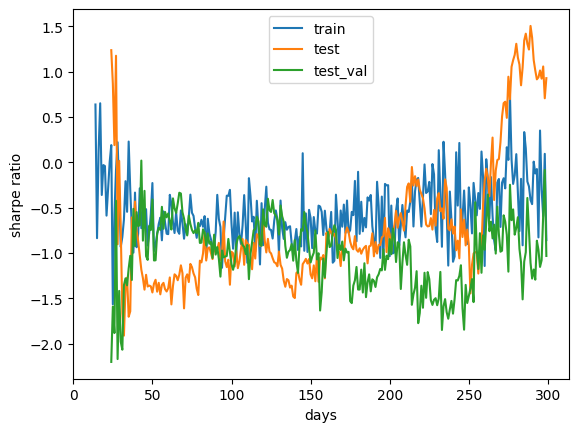

-0.6436329409312125 0.7198110621812682
-0.9309183582039733 0.4548457510181556
(300,) [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.10069908 -0.20417878  0.08394448 -1.44673257 -1.24170922
 -2.20276121 -1.59301364 -1.88424397 -0.42508776 -2.17130689 -1.41943923
 -1.98050484 -2.06788572 -1.35598818 -1.28047755 -1.35770111 -1.17176426
 -1.03226296 -1.29884384 -0.51426427 -0.92470329 -0.55026186 -0.70503004
 -0.69380455  0.01797345 -0.86500071 -0.31577821 -1.03563168 -1.077471
 -0.69989608 -0.74851867 -0.41089968 -1.08377299 -1.08152468 -0.78510376
 -0.72367014 -0.74670882 -0.49175326 -0.73351944 -0.54739108 -0.60813898
 -0.56453968 -0.64613047 -0.74244023 -0.39889322 -0.50875854 -0.55895384
 -0.4545465  -0.3365909  -0.34521903 -0.55110428 -0.62229637 -0.73520447
 -0.80733687 -0.58837833 -0.68080601 -0.74708017 -0.78172701 -0.7

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_sharpe_l, label="train")
#plt.plot(valid_sharpe_l, label="valid")
plt.plot(test_sharpe_l, label="test")
plt.plot(1*np.asarray(valid_sharpe_l)+0*np.asarray(test_sharpe_l), label="test_val")
plt.xlabel('days')
plt.ylabel('sharpe ratio')
plt.legend()
plt.show()
#print(0.5*(np.asarray(valid_sharpe_l)+np.asarray(test_sharpe_l)))
test_l=np.nan_to_num(np.asarray(test_sharpe_l[:]))
test_val_l=np.nan_to_num(1*(np.asarray(valid_sharpe_l[:])))
print(np.mean(test_l),np.std(test_l))
print(np.mean(test_val_l),np.std(test_val_l))
print(test_l.shape,test_val_l)
#print(y_true)

In [ ]:
torch.save(model.state_dict(), '/content/model_02.pth')

In [ ]:
def sharpe(action, true_return,label,multi_state=False):
  res=0
  l=len(action)

  count,count_short,count_long,count_short_l,count_long_l=0,0,0,0,0
  trading_res=np.zeros(shape=true_return.shape)

  #print(true_return.shape)



  if multi_state:
      for i in range(l):
        for j in range(len(action[i])):
          for k in range(5):

              if label[i][j,k]==0:
                count_short_l+=1
              if label[i][j,k]==2:
                count_long_l+=1

              if action[i][j,k]==0:
                count_short+=1

                trading_res[count,k]=-true_return[count,k]
              if action[i][j,k]==2:
                count_long+=1

                trading_res[count,k]=+true_return[count,k]

          count+=1
  else:
        for i in range(l):
          for j in range(len(action[i])):
            if label[i][j]==0:
              count_short_l+=1
            if label[i][j]==2:
              count_long_l+=1

            if action[i][j]==0:
              count_short+=1

              trading_res[count]=-true_return[count]
            if action[i][j]==2:
              count_long+=1

              trading_res[count]=true_return[count]

            count+=1
  if multi_state:
      sharpe_comb=np.sqrt(252)*np.mean(np.sum(trading_res,axis=1))/np.std(np.sum(trading_res,axis=1))
      sharpe_1=np.sqrt(252)*np.mean(trading_res,axis=0)/np.std(trading_res,axis=0)
      ceq=np.mean(np.sum(trading_res,axis=1))-0.5*(np.std(np.sum(trading_res,axis=1))**2)
      ceq_1=np.mean(trading_res,axis=0)-0.5*(np.std(trading_res,axis=0)**2)
      long_sharpe=np.sqrt(252)*np.mean(np.sum(true_return,axis=1))/np.std(np.sum(true_return,axis=1))





  else:
      sharpe_comb=np.sqrt(252)*np.mean(trading_res)/np.std(trading_res)
      long_sharpe=np.sqrt(252)*np.mean(true_return)/np.std(true_return)
      sharpe_1=0
  #print(count,count_short,count_long,count_short_l,count_long_l)

  return count_short,count_long,count_short_l,count_long_l,sharpe_comb,sharpe_1 ,long_sharpe,ceq,ceq_1
def generate_random(label,true_return):
    res=0
    l=len(label)

    count,count_short,count_long,count_short_l,count_long_l=len(true_return),0,0,0,0
    for i in range(l):
      for j in range(len(label[i])):
        if label[i][j]==0:
          count_short_l+=1
        if label[i][j]==2:
          count_long_l+=1
    generated=np.random.choice(3,count, p=[0, 1-count_short_l/count-count_long_l/count, count_short_l/count+count_long_l/count])
    random_return=np.multiply((generated-1),true_return)


    return np.sqrt(252)*np.mean(random_return)/np.std(random_return)






Model_01 on Nasdaq

sharpe ratio 1.459
always long strategy sharpe 2.049
flip coin sharpe mean and std
0.969 1.125

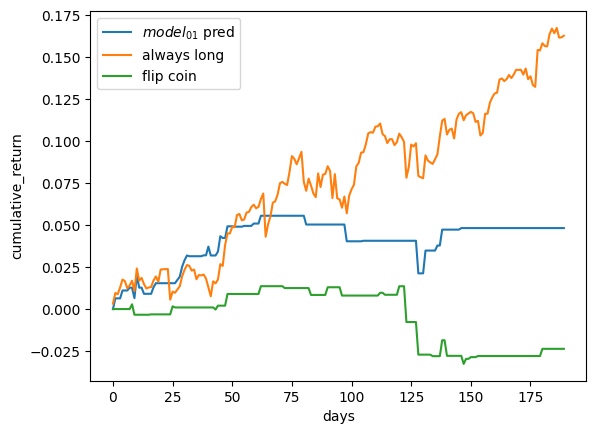

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return_cum, label="$model_{01}$ pred")
plt.plot(y_pred_return_cum, label="always long")
plt.plot(y_true_flip_return_cum, label="flip coin")
plt.xlabel('days')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

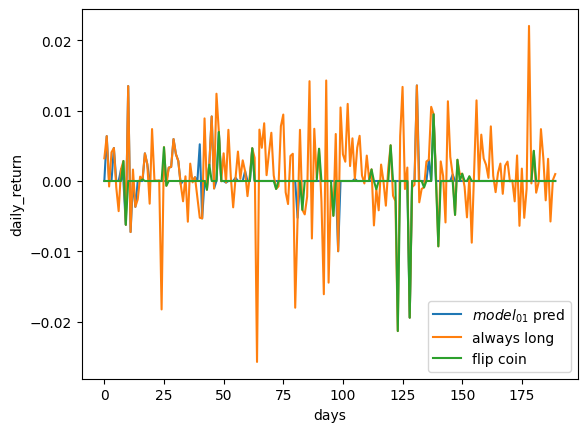

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return, label="$model_{01}$ pred")
plt.plot(y_pred_return, label="always long")
plt.plot(y_true_flip_return, label="flip coin")
plt.xlabel('days')
plt.ylabel('daily_return')
plt.legend()
plt.show()

model_01 on SP500
sharpe ratio 0.9718
always long strategy sharpe 1.9032
flip coin sharpe mean and std
0.7856 1.095

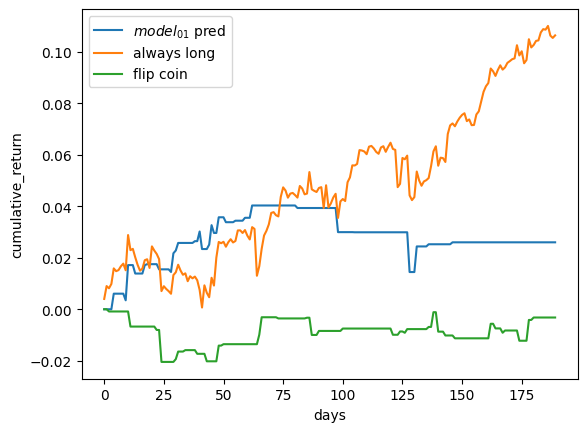

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return_cum, label="$model_{01}$ pred")
plt.plot(y_pred_return_cum, label="always long")
plt.plot(y_true_flip_return_cum, label="flip coin")
plt.xlabel('days')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

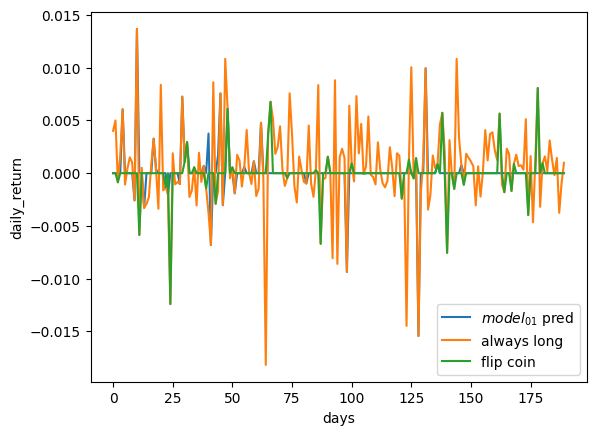

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return, label="$model_{01}$ pred")
plt.plot(y_pred_return, label="always long")
plt.plot(y_true_flip_return, label="flip coin")
plt.xlabel('days')
plt.ylabel('daily_return')
plt.legend()
plt.show()

model_02 on sp500
sharpe ratio 2.241
always long strategy sharpe 1.903
flip coin sharpe mean and std
0.62 1.03

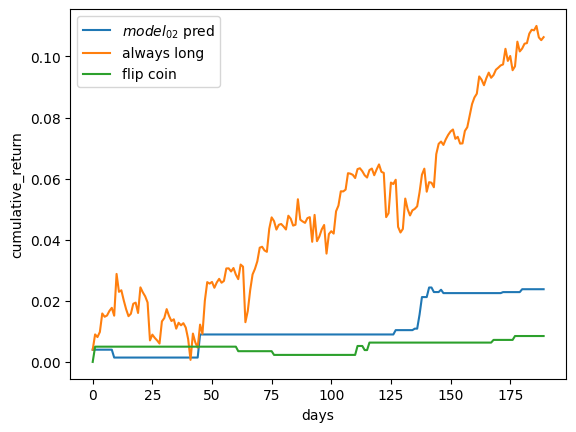

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return_cum, label="$model_{02}$ pred")
plt.plot(y_pred_return_cum, label="always long")
plt.plot(y_true_flip_return_cum, label="flip coin")
plt.xlabel('days')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

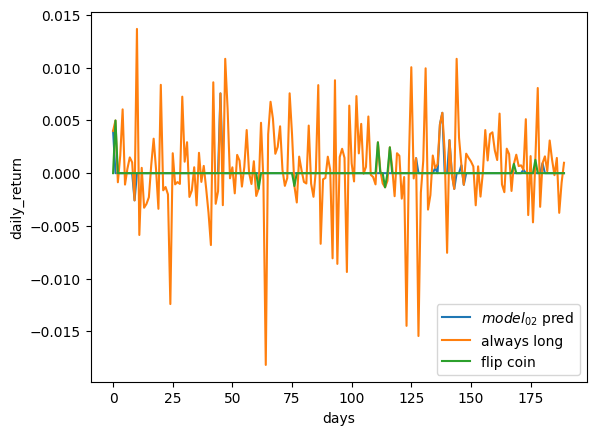

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return, label="$model_{02}$ pred")
plt.plot(y_pred_return, label="always long")
plt.plot(y_true_flip_return, label="flip coin")
plt.xlabel('days')
plt.ylabel('daily_return')
plt.legend()
plt.show()

model_02 on sp500
sharpe ratio 1.929
always long strategy sharpe 2.049
flip coin sharpe mean and std
0.923 0.9950

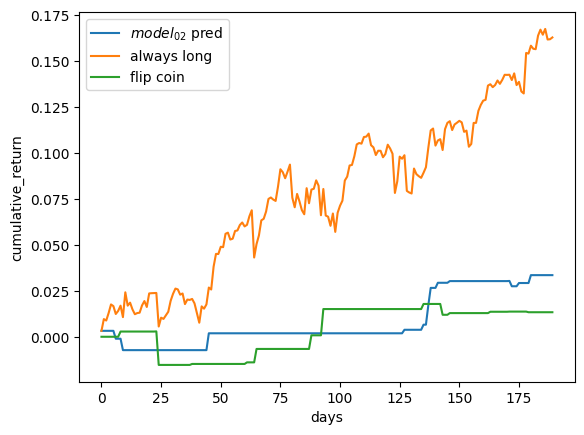

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return_cum, label="$model_{02}$ pred")
plt.plot(y_pred_return_cum, label="always long")
plt.plot(y_true_flip_return_cum, label="flip coin")
plt.xlabel('days')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

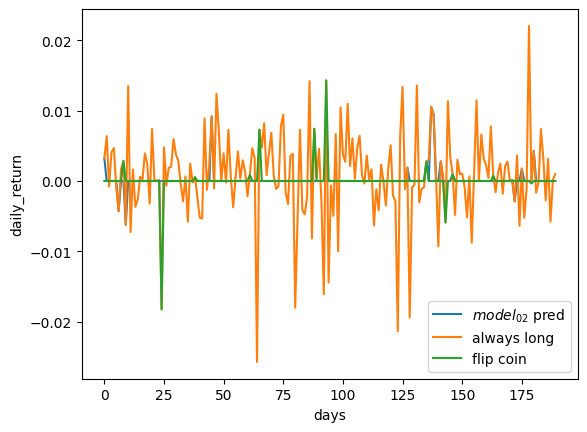

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return, label="$model_{02}$ pred")
plt.plot(y_pred_return, label="always long")
plt.plot(y_true_flip_return, label="flip coin")
plt.xlabel('days')
plt.ylabel('daily_return')
plt.legend()
plt.show()

From tuning on hyperparameters of GAT,
we notice that both models have large variance. The positional encoding idea performs worth than the simple binary split. This is intuitive for the following reasion: From the histogram, the higher and lower threshold is not a nice split if we divide in to 30-40-30.  Also, we notice that the independence prediction(last layer of the model) is not a standard approach like most classification problem, like CIFAR10.
Several further directions can be worth exploring: 1. instead of a fixed graph. it might be helpful if the graph structure for each datapoint is purely based on locally past information. 2. instead of looking at 1 day return, the performance wound be enhanced by switching to several days return to remove too much noise. 3. adding random noise to the 82-dim data 4. a LSTM encoder placed before the first layer of GAT would help with the time series part(in both models, we only had a fully connected layer)
To better evaluate the performnace, it is useful to have a practical baseline like always long/ random guess. Sharpe ratio is also worth computing. Besides sp500, it is helpful to employ the model (with out any further training) on other targets, like european market, NASDAQ.


Acknowledgement:
The code for data preprocess is from the original paper.



For Sharpe ratio, all long has a 1.98 for s&p500; 1.16 for RUSSELL. we have a sharpe ration 0.5-0.7 for sp500. However, for a sharpe ratio 0.69 fro sp500, if we impose the model on russell data, we reach a 1.53 sharpe ratio(!)

Train on russell result

semi-confusion matrix, test acc, sharpe ratio (sp500_test) (sp500_train)

0 29 0 149, 0.34563; 0 15 0 169, 0.332,1.344;0 150 0 102,0.634 0.39834, (0.93991) the sharpe of train for all long strategy;

0 1 0 6,0.741, 0.360; 0 1 0 6,0.825,0.804;0 87 2 60,0.617,0.899;

0 25 1 160,0.29,1.189;0 14 4 184,0.268,0.927;0 145 1 105,0.621,0.326

Train on sp500 result

semi-confusion matrix, test acc, sharpe ratio (russel_test) (ressul_train)

0 10 0 112,0.493,0.7499;0 16 0 100,0.466,0.913;0 134 0 80,0.642,0.566,0.789 the sharpe of train for all long strategy;

0 1 3 3,0.818,-0.756;0 1 1 4,0.7416,0.0147;23 120 26 76,0.625,0.451;

0 5 0 39,0.718,0.648;0 6 0 40,0.637,0.061;1 132 0 89,0.624,0.223


model_01 (num_layers=15,
            mid_dim=[20,40,3],) is trained on sp500 with 3 days return and split date '2016-09-21'.
ON sp500 it performed (2, 27, 11, 7, 1.3308871499998605, 3.833384856510234)
-0.2566652213680659 1.0500062032154167 with [tensor([1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 2, 2, 2, 2]), tensor([1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 1, 2, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])]


On nasdaq, it performed (1, 34, 18, 15, 2.1488382542222246, 3.982246153766872)
-0.21532031635079146 1.2455147836112512 with [tensor([1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2,
        1, 1, 1, 2, 2, 2, 2, 2]), tensor([2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 1, 2, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])]


model_02 (num_layers=10,
            mid_dim=[20,40,3],) is trained on nasdaq with 3 days return and split date '2016-09-21'.
ON nasdaq: it performed

(0, 14, 18, 15, 1.1322208743470898, 3.982246153766872)
-0.1650096120166451 1.2495939812570136 with [tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2]), tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1])]
On SP500 it performed (0, 13, 11, 7, 2.0081559644781124, 3.833384856510234)
-0.12541916267625278 1.2610346018366652 with
[tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2]), tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1])]

On NYSE, it performed(0, 13, 11, 8, 2.854867342774881, 2.6912229749270975)
-0.0511126680283859 1.1013084584998725 with [tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1])]

model_02
This is a sanity check: model_02 applied on sp500 at training data(2010-2016).  sharpe ratio 2.548, always long 0.9247

1169 195 218 234 236
(195, 218, 234, 236, 2.54826789713981, 0.924706458493619)
0.5854505025991693 0.3604010798362735


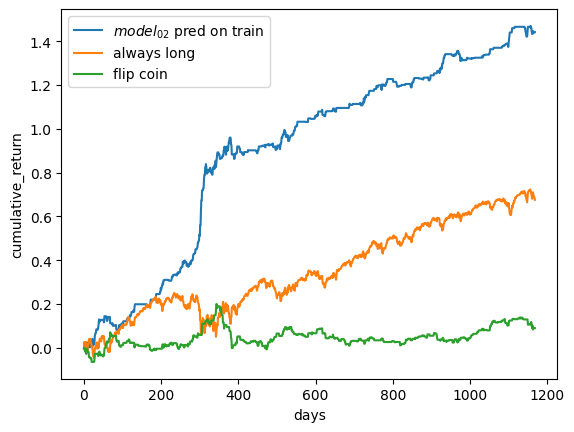

In [ ]:
acc_val,score_val,y_true,y_pred = eval_1(model, device, my_dataloader, evaluator, pbar)
print(sharpe(y_true,return_true_train,y_pred))
random_l=np.zeros(shape=(500))
for i in range(500):
  random_l[i]=generate_random(y_pred,return_true_train)
print(np.mean(random_l),np.std(random_l))

y_true_np=turn_to_np(y_true,1169)
y_pred_np=turn_to_np(y_pred,1169)

y_true_return_cum,y_true_return=return_np(y_true_np,return_true_train)
y_pred_return_cum,y_pred_return=return_np(1+np.ones(shape=1169),return_true_train)
y_pred_flip_coin_np=np.random.choice(3,1169, p=[195/1169,1-195/1169-218/1169,218/1169])
y_true_flip_return_cum,y_true_flip_return=return_np(y_pred_flip_coin_np,return_true_train)

plt.plot(y_true_return_cum, label="$model_{02}$ pred on train")
plt.plot(y_pred_return_cum, label="always long")
plt.plot(y_true_flip_return_cum, label="flip coin")
plt.xlabel('days')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

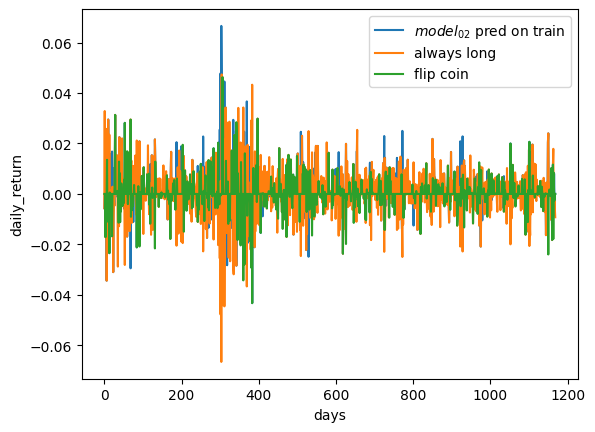

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return, label="$model_{02}$ pred on train")
plt.plot(y_pred_return, label="always long")
plt.plot(y_true_flip_return, label="flip coin")
plt.xlabel('days')
plt.ylabel('daily_return')
plt.legend()
plt.show()

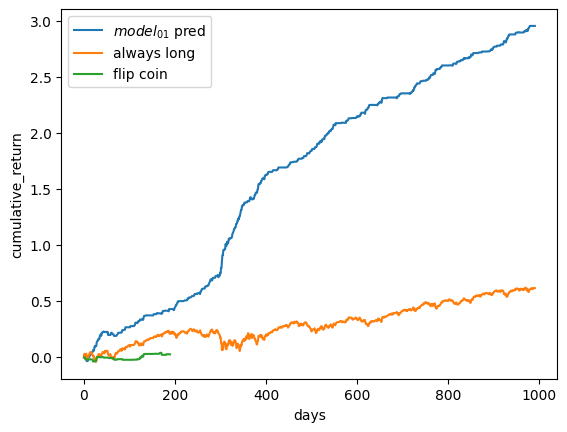

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return_cum, label="$model_{01}$ pred")
plt.plot(y_pred_return_cum, label="always long")
plt.plot(y_true_flip_return_cum, label="flip coin")
plt.xlabel('days')
plt.ylabel('cumulative_return')
plt.legend()
plt.show()

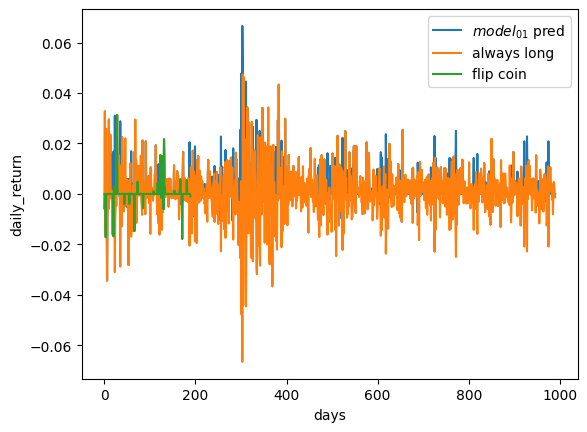

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_true_return, label="$model_{01}$ pred")
plt.plot(y_pred_return, label="always long")
plt.plot(y_true_flip_return, label="flip coin")
plt.xlabel('days')
plt.ylabel('daily_return')
plt.legend()
plt.show()

In this section, we will focus on trading strategies that are derived from all graph-CNN models in the section before.  Recall in the labeling subsection, we provided two system of labelling strategies, which the second one is a 3 category labelling strategy. Explicitly, the second labeling reveals the 3 categories:  if the daily return of the stock is significantly positive, it is labeled as "up", if it is significantly negative, it is labeled as "down", and if it is close to zero, it is labeled as "unchanged". In the implementation process, we give a one-hot encoding to the 3 categories.
In this section, this label directly forms a trading strategy: if the maximum of the result in day t is in dimension 1, which indicates the price will go up, then we hold a long position, similarly for the price will go down. If the maximum of the result in day t is in dimension 2, which indicates the price does not vary too much then we close the position if we hold a long/short position, or do not act.